In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
images_folder = Path("dog-breed-identification")
train_folder = images_folder / "train_resized"
test_folder = images_folder / "test"

In [15]:
image_shape = (200, 200, 3)
full_dataset = image_dataset_from_directory(train_folder, batch_size=32, label_mode='categorical', image_size=(image_shape[0], image_shape[1]))
full_dataset.shuffle(10222, seed=1)

test_dataset = full_dataset.take(10)
train_dataset = full_dataset.skip(10)

Found 10222 files belonging to 120 classes.


(32, 200, 200, 3)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)


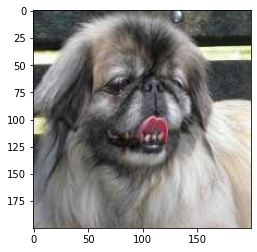

In [17]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels[0])
    plt.imshow(images[0].numpy().astype("uint8"))


In [18]:
pretrained_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=image_shape)

In [19]:
pretrained_model.summary()

_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_0_bn (BatchNormali (None, 6, 6, 608)    2432        conv5_block3_concat[0][0]        
__________________________________________________________________________________________________
conv5_block4_0_relu (Activation (None, 6, 6, 608)    0           conv5_block4_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block4_1_conv (Conv2D)    (None, 6, 6, 128)    77824       conv5_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_bn (BatchNormali (None, 6, 6, 128)    512         conv5_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_relu (Activation (None, 6, 6, 128)    0           conv5_block4_1_bn[0][0] 

In [20]:
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

In [21]:
pretrained_model.trainable = False

model = Sequential([
    layers.Lambda(preprocess_input, input_shape=image_shape),
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(120, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 6, 6, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               123000    
Total params: 7,160,504
Trainable params: 123,000
Non-trainable params: 7,037,504
_________________________________________________________________


In [23]:
model.compile(
    optimizer = 'adam',
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True
)

In [28]:
history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=test_dataset
)

 12/310 [>.............................] - ETA: 1:56:08 - loss: 5.2421 - accuracy: 0.0573

KeyboardInterrupt: 

In [ ]:
history